In [1]:
import json
import base64
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from scipy import stats
import torch
from torchvision import transforms
from PIL import Image

# Import your models
from mnist_skeptic_v9 import skeptic_v9  # Ensure this path is correct

# Additional imports for model ensemble
import os
import string

import torchvision.transforms as transforms
import ipywidgets as widgets
from IPython.display import display

import zipfile
from io import BytesIO

import seaborn as sns

In [2]:
def decode_base64_image(base64_string_or_list):
    if isinstance(base64_string_or_list, list):
        # If it's a list, assume the first item is the base64 string
        base64_string = base64_string_or_list[0]
    else:
        base64_string = base64_string_or_list
    
    try:
        img_data = base64.b64decode(base64_string.split(',')[1])
    except IndexError:
        # If there's no comma, try decoding the whole string
        img_data = base64.b64decode(base64_string)
    
    return Image.open(BytesIO(img_data))

In [3]:
def calculate_vviq_scores(vviq_data):
    def transform_score(score):
        score = int(score)
        if 0 <= score <= 4:
            return 5 - score  # Reverse the scoring
        else:
            raise ValueError(f"Invalid score: {score}. Expected 0-4.")

    scores_open = []
    scores_closed = []
    attention_checks = []

    for condition in ['open', 'closed']:
        for item in vviq_data[condition]:
            for key, value in item.items():
                if key.startswith('row'):
                    if key == 'row4' and item == vviq_data[condition][-1]:
                        # This is an attention check item
                        attention_checks.append(int(value))
                    else:
                        # This is a regular item
                        try:
                            transformed_score = transform_score(value)
                            if condition == 'open':
                                scores_open.append(transformed_score)
                            else:
                                scores_closed.append(transformed_score)
                        except ValueError as e:
                            print(f"Error in VVIQ data: {e}")

    # Ensure we have exactly 16 scores for each condition
    if len(scores_open) != 16 or len(scores_closed) != 16:
        print(f"Warning: Expected 16 VVIQ items for each condition, but found {len(scores_open)} (open) and {len(scores_closed)} (closed)")

    # Calculate scores
    absolute_score_open = sum(scores_open)
    absolute_score_closed = sum(scores_closed)
    absolute_score_total = absolute_score_open + absolute_score_closed

    normalized_score_open = (absolute_score_open - 16) / 64
    normalized_score_closed = (absolute_score_closed - 16) / 64
    normalized_score_total = (absolute_score_total - 32) / 128

    # Check if attention checks were passed
    attention_check_passed = all(check == 4 for check in attention_checks)

    return {
        'absolute_score_open': absolute_score_open,
        'absolute_score_closed': absolute_score_closed,
        'absolute_score_total': absolute_score_total,
        'normalized_score_open': normalized_score_open,
        'normalized_score_closed': normalized_score_closed,
        'normalized_score_total': normalized_score_total,
        'attention_check_passed': attention_check_passed,
        'num_items_open': len(scores_open),
        'num_items_closed': len(scores_closed)
    }

Just need to clarify something with myself here:

1. VVIQ (Vividness of Visual Imagery Questionnaire):
   The scoring for VVIQ is correct. Higher scores indicate less vivid imagery.

2. CAPS (Cardiff Anomalous Perceptions Scale):
   The current scoring seems to be correct as well. Higher scores indicate more anomalous perceptions.

The issue is that the correlations don't make intuitive sense. We would expect:

- A negative correlation between VVIQ and CAPS (as vivid imagery increases, anomalous perceptions should increase)
- A positive correlation between VVIQ and training accuracy (as vivid imagery decreases, training accuracy should decrease)
- A positive correlation between CAPS and training accuracy (as anomalous perceptions increase, training accuracy should increase)

To address this, we need to reverse the scoring of the VVIQ. This will make the interpretation more intuitive: higher scores will indicate more vivid imagery. 

After making this change the correlations should now make more theoretical sense:

- A positive correlation between VVIQ and CAPS (both high scores indicate more vivid imagery/anomalous perceptions)
- A positive correlation between VVIQ and training accuracy
- A positive correlation between CAPS and training accuracy

In [4]:
def calculate_caps_scores(responses):
    # Initialize scores
    total_caps_score = 0
    visual_caps_score = 0
    distress_score = 0
    distracting_score = 0
    frequency_score = 0
    visual_distress_score = 0
    visual_distracting_score = 0
    visual_frequency_score = 0
    
    # Visual perception items
    visual_questions = [4, 19, 22, 23, 26, 31]
    
    for response in responses:
        question_number = response['question_number']
        if response['response'] == 'yes':
            total_caps_score += 1
            
            # Add subscale scores if available
            if 'subscale' in response:
                # Reverse the scoring (assuming a 5-point scale)
                distress_score += int(response['subscale']['subscale_0'])
                distracting_score += int(response['subscale']['subscale_1'])
                frequency_score += int(response['subscale']['subscale_2'])
            
            # Check if it's a visual perception question
            if question_number in visual_questions:
                visual_caps_score += 1
                if 'subscale' in response:
                    visual_distress_score += int(response['subscale']['subscale_0'])
                    visual_distracting_score += int(response['subscale']['subscale_1'])
                    visual_frequency_score += int(response['subscale']['subscale_2'])
    
    return {
        'total_caps_score': total_caps_score,
        'visual_caps_score': visual_caps_score,
        'total_distress_score': distress_score,
        'total_distracting_score': distracting_score,
        'total_frequency_score': frequency_score,
        'visual_distress_score': visual_distress_score,
        'visual_distracting_score': visual_distracting_score,
        'visual_frequency_score': visual_frequency_score,
        'total_dimensional_score': distress_score + distracting_score + frequency_score,
        'visual_dimensional_score': visual_distress_score + visual_distracting_score + visual_frequency_score
    }

In [5]:
def preprocess_participant_data(participant_data):
    # Extract demographic data
    demographics = participant_data['demographics']
    
    # Process VVIQ data
    vviq_data = participant_data['vviq']
    vviq_scores = calculate_vviq_scores(vviq_data)
    
    # Process CAPS data
    caps_data = participant_data['caps']
    caps_scores = calculate_caps_scores(caps_data)
    
    # Process training trials
    training_trials = [trial for trial in participant_data['trials'] if trial.get('trial_type') == 'training']
    training_trials_scores = [trial.get('correct', False) for trial in training_trials]
    correct_training_trials = sum(training_trials_scores)
    training_accuracy = (correct_training_trials / len(training_trials)) * 100 if training_trials else 0
    training_condition = training_trials[0]['condition'] if training_trials else None
    
    # Process main experiment trials
    main_trials = [trial for trial in participant_data['trials'] if 'block_number' in trial]
    main_condition = main_trials[0]['condition'] if main_trials else None
    
    # Extract images
    training_images = [decode_base64_image(trial['stimuli'][trial['selected_index']]) for trial in training_trials]
    
    selected_images = {1: [], 2: []}
    non_selected_images = {1: [], 2: []}
    for trial in main_trials:
        block = trial['block_number']
        for stimulus in trial['stimuli']:
            img = decode_base64_image(stimulus['dataURL'])
            if stimulus['selected']:
                selected_images[block].append(img)
            else:
                non_selected_images[block].append(img)
    
    return {
        'participant_id': participant_data['participant_id'],
        'demographics': demographics,
        'vviq_scores': vviq_scores,
        'caps_scores': caps_scores,
        'training_accuracy': training_accuracy,
        'training_condition': training_condition,
        'training_trials_scores': training_trials_scores,  # Add this new line
        'main_condition': main_condition,
        'training_images': training_images,
        'selected_images': selected_images,
        'non_selected_images': non_selected_images
    }

In [6]:
def create_summary_dataframe(all_participants_data):
    summary_data = []
    for participant_id, data in all_participants_data.items():
        participant_summary = {
            'participant_id': participant_id,
            'age': data['demographics']['age'],
            'gender': data['demographics']['gender'],
            'vviq_absolute_score_open': data['vviq_scores']['absolute_score_open'],
            'vviq_absolute_score_closed': data['vviq_scores']['absolute_score_closed'],
            'vviq_absolute_score_total': data['vviq_scores']['absolute_score_total'],
            'vviq_normalized_score_open': data['vviq_scores']['normalized_score_open'],
            'vviq_normalized_score_closed': data['vviq_scores']['normalized_score_closed'],
            'vviq_normalized_score_total': data['vviq_scores']['normalized_score_total'],
            'vviq_attention_check_passed': data['vviq_scores']['attention_check_passed'],
            'caps_total_score': data['caps_scores']['total_caps_score'],
            'caps_visual_score': data['caps_scores']['visual_caps_score'],
            'training_accuracy': data['training_accuracy'],
            'training_condition': data['training_condition'],
            'main_condition': data['main_condition'],
            'num_selected_block1': len(data['selected_images'][1]),
            'num_selected_block2': len(data['selected_images'][2]),
            
            # Predefine placeholders for composites
            'training_composite': None,
            'block1_standard_composite': None,
            'block2_standard_composite': None,
            'block1_2_standard_composite': None,
            'block1_enhanced_composite': None,
            'block2_enhanced_composite': None,
            'block1_2_enhanced_composite': None
        }

        # Add training_trials_scores
        if 'training_trials_scores' in data:
            for i, score in enumerate(data['training_trials_scores']):
                participant_summary[f'training_trial_{i+1}'] = score

        summary_data.append(participant_summary)

    return pd.DataFrame(summary_data)

In [7]:
def load_and_preprocess_data(file_path):
    all_participants_data = {}
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith('.txt'):
                with zip_ref.open(file_name) as file:
                    participant_data = json.load(file)
                    processed_data = preprocess_participant_data(participant_data)
                    all_participants_data[processed_data['participant_id']] = processed_data
    return all_participants_data

In [8]:
# Load and preprocess data
file_path = 'jatos_results_20241107110614.jrzip'
all_participants_data = load_and_preprocess_data(file_path)

# Create summary dataframe
summary_df = create_summary_dataframe(all_participants_data)

print("Initial number of participants:", len(summary_df))

Initial number of participants: 9


In [9]:
# Identify participants who failed the attention check or had 0% training accuracy
failed_attention_check = summary_df[~summary_df['vviq_attention_check_passed']]
zero_training_accuracy = summary_df[summary_df['training_accuracy'] == 0]

print("\nParticipants who failed the attention check:")
print(failed_attention_check[['participant_id', 'vviq_attention_check_passed']])

print("\nParticipants with 0% training accuracy:")
print(zero_training_accuracy[['participant_id', 'training_accuracy']])

# Remove these participants
summary_df = summary_df[summary_df['vviq_attention_check_passed'] & (summary_df['training_accuracy'] > 0)]

print("\nFinal number of participants:", len(summary_df))


Participants who failed the attention check:
  participant_id  vviq_attention_check_passed
2          88755                        False
8          00000                        False

Participants with 0% training accuracy:
  participant_id  training_accuracy
0             10                0.0
2          88755                0.0

Final number of participants: 6


Correlations:
                           vviq_absolute_score_total  caps_total_score  \
vviq_absolute_score_total                   1.000000          0.791949   
caps_total_score                            0.791949          1.000000   
caps_visual_score                           0.456173          0.610170   
training_accuracy                           0.502114          0.336219   

                           caps_visual_score  training_accuracy  
vviq_absolute_score_total           0.456173           0.502114  
caps_total_score                    0.610170           0.336219  
caps_visual_score                   1.000000          -0.186501  
training_accuracy                  -0.186501           1.000000  

P-values:
                          vviq_absolute_score_total caps_total_score  \
vviq_absolute_score_total                       NaN         0.060425   
caps_total_score                           0.060425              NaN   
caps_visual_score                          0.363204       

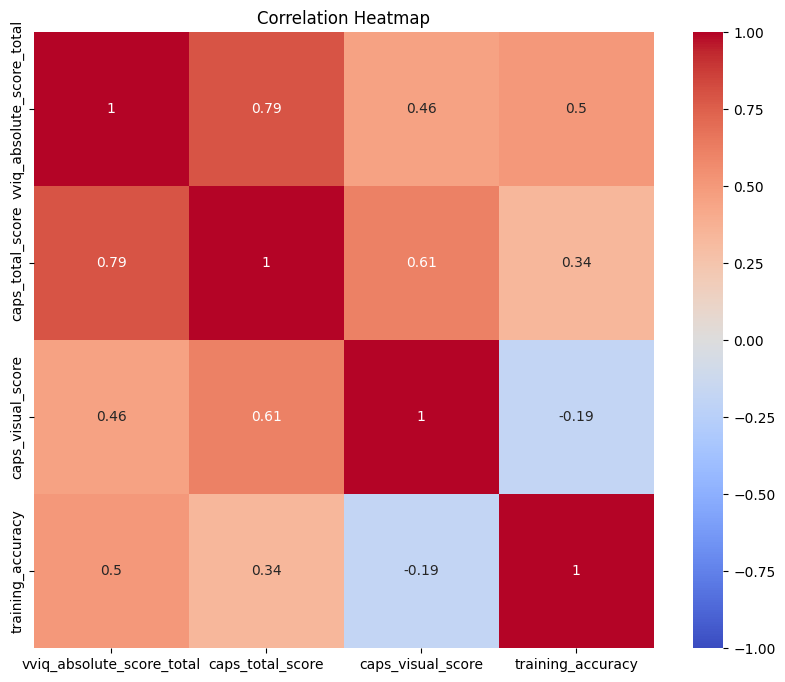


Specific Correlations of Interest:
VVIQ vs Overall CAPS:
 Correlation coefficient: 0.7919
 p-value: 0.0604

VVIQ vs Visual CAPS:
 Correlation coefficient: 0.4562
 p-value: 0.3632

VVIQ vs Training Accuracy:
 Correlation coefficient: 0.5021
 p-value: 0.3101

Overall CAPS vs Training Accuracy:
 Correlation coefficient: 0.3362
 p-value: 0.5147



In [10]:
def analyze_correlations(summary_df):
    # Define the variables we want to correlate
    variables = ['vviq_absolute_score_total', 'caps_total_score', 'caps_visual_score', 'training_accuracy']
    
    # Create a correlation matrix
    corr_matrix = summary_df[variables].corr()
    
    # Calculate p-values
    p_values = pd.DataFrame(columns=variables, index=variables)
    for i in variables:
        for j in variables:
            if i != j:
                r, p = stats.pearsonr(summary_df[i], summary_df[j])
                p_values.loc[i, j] = p
    
    # Print correlations and p-values
    print("Correlations:")
    print(corr_matrix)
    print("\nP-values:")
    print(p_values)
    
    # Create a heatmap of correlations
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap')
    plt.show()
    
    # Specific correlations of interest
    correlations_of_interest = [
        ('VVIQ', 'Overall CAPS', 'vviq_absolute_score_total', 'caps_total_score'),
        ('VVIQ', 'Visual CAPS', 'vviq_absolute_score_total', 'caps_visual_score'),
        ('VVIQ', 'Training Accuracy', 'vviq_absolute_score_total', 'training_accuracy'),
        ('Overall CAPS', 'Training Accuracy', 'caps_total_score', 'training_accuracy')
    ]
    
    print("\nSpecific Correlations of Interest:")
    for corr in correlations_of_interest:
        r, p = stats.pearsonr(summary_df[corr[2]], summary_df[corr[3]])
        print(f"{corr[0]} vs {corr[1]}:")
        print(f" Correlation coefficient: {r:.4f}")
        print(f" p-value: {p:.4f}")
        print()

# Run the analysis
analyze_correlations(summary_df)

1. VVIQ vs Overall CAPS:
   Correlation coefficient: 0.7919, p-value: 0.0604
   This is a strong positive correlation, very close to being statistically significant at the conventional p < 0.05 level. It suggests that higher vividness of visual imagery is associated with more anomalous perceptions, which aligns with our expectations.

2. VVIQ vs Visual CAPS:
   Correlation coefficient: 0.4562, p-value: 0.3632
   This is a moderate positive correlation, though not statistically significant. It still suggests a trend in the expected direction: higher visual imagery vividness is associated with more visual anomalous perceptions.

3. VVIQ vs Training Accuracy:
   Correlation coefficient: 0.5021, p-value: 0.3101
   This moderate positive correlation suggests that higher visual imagery vividness is associated with better training accuracy, which also aligns with our expectations.

4. Overall CAPS vs Training Accuracy:
   Correlation coefficient: 0.3362, p-value: 0.5147
   This weak to moderate positive correlation suggests a slight tendency for those with more anomalous perceptions to perform better in training, though this relationship is not statistically significant.

While none of these correlations reach statistical significance at the conventional p < 0.05 level, they all show trends in the directions we expected. The lack of statistical significance is likely due to the small sample size, which limits the power to detect significant effects.

The correlation between VVIQ and Overall CAPS is particularly noteworthy, as it's very close to statistical significance (p = 0.0604). With a slightly larger sample size, this relationship might well become statistically significant.

These results are encouraging for our hypotheses, especially given the small sample size. They suggest that:

1. There's a strong tendency for vivid visual imagery to be associated with more anomalous perceptions.
2. Vivid visual imagery tends to be associated with better performance in the training task.
3. There's a weak to moderate tendency for anomalous perceptions to be associated with better training performance.

In [11]:
def plot_training_accuracy(summary_df):
    plt.figure(figsize=(12, 8))
    
    # Get a color palette with enough colors for all participants
    num_participants = len(summary_df)
    color_palette = sns.color_palette("husl", n_colors=num_participants)
    
    for i, (_, participant) in enumerate(summary_df.iterrows()):
        training_trials_scores = [participant[f'training_trial_{i}'] for i in range(1, 11) if f'training_trial_{i}' in participant]
        if training_trials_scores:
            cumulative_accuracy = [sum(training_trials_scores[:i+1]) / (i+1) * 100 for i in range(len(training_trials_scores))]
            
            # Add slight jitter to 100% accuracy lines
            if all(acc == 100 for acc in cumulative_accuracy):
                cumulative_accuracy = [99.9 + np.random.uniform(0, 0.1) for _ in cumulative_accuracy]
            
            plt.plot(range(1, len(cumulative_accuracy) + 1), cumulative_accuracy, 
                     alpha=0.7, linewidth=2, color=color_palette[i])
    
    plt.xlabel('Training Trial Number')
    plt.ylabel('Cumulative Accuracy (%)')
    plt.title('Training Accuracy Trajectory for Each Participant')
    plt.xlim(1, 10)
    plt.ylim(0, 101)  # Extend y-axis slightly above 100%
    plt.xticks(range(1, 11))
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add a legend with the participant IDs
    legend_elements = [plt.Line2D([0], [0], color=color_palette[i], lw=2, 
                                  label=f'Participant {pid}') 
                       for i, pid in enumerate(summary_df['participant_id'])]
    plt.legend(handles=legend_elements, title='Participants', 
               loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

    # Plot overall accuracy distribution for all participants
    plt.figure(figsize=(10, 6))
    sns.histplot(summary_df['training_accuracy'], kde=True, bins=7)
    plt.xlabel('Overall Training Accuracy (%)')
    plt.ylabel('Count')
    plt.title('Distribution of Overall Training Accuracy')
    plt.show()

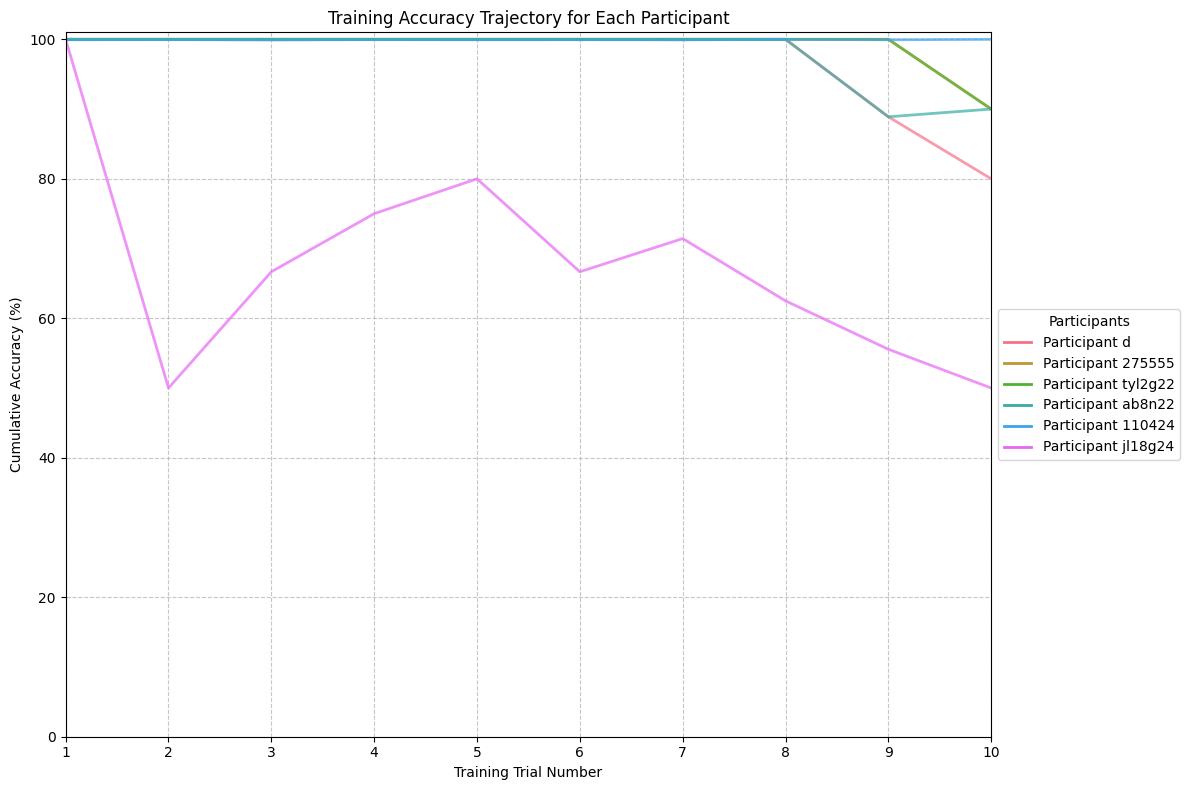

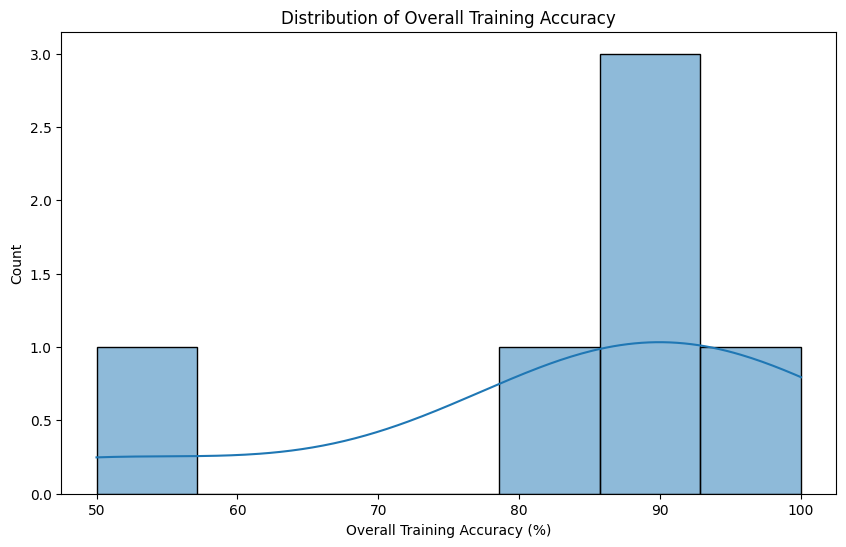

In [12]:
plot_training_accuracy(summary_df)

In [13]:
def create_composite_image(images):
    if not images:
        return np.zeros((16, 16), dtype=np.uint8)
    np_images = [np.array(img.convert('L').resize((16, 16))) for img in images]
    mean_image = np.mean(np.stack(np_images), axis=0)
    return mean_image.astype(np.uint8)

def create_enhanced_composite(selected_images, non_selected_images):
    enhanced_trials = []
    for selected, non_selected_set in zip(selected_images, non_selected_images):
        selected_array = np.array(selected.convert('L').resize((16, 16)))
        non_selected_arrays = [np.array(img.convert('L').resize((16, 16))) for img in non_selected_set]
        avg_non_selected = np.mean(non_selected_arrays, axis=0)
        enhanced_trial = selected_array.astype(np.int16) - avg_non_selected.astype(np.int16)
        enhanced_trials.append(np.clip(enhanced_trial, 0, 255).astype(np.uint8))
    return np.mean(enhanced_trials, axis=0).astype(np.uint8)

In [14]:
def analyze_participant(participant_data):
    # Create training composite
    training_composite = create_composite_image(participant_data['training_images'])
    
    # Create standard composites
    standard_composites = {}
    enhanced_composites = {}
    
    for block in [1, 2]:
        selected = participant_data['selected_images'][block]
        non_selected = participant_data['non_selected_images'][block]
        
        # Standard composite
        standard_composites[block] = create_composite_image(selected)
        
        # Enhanced composite
        non_selected_reshaped = [non_selected[i:i+9] for i in range(0, len(non_selected), 9)]
        enhanced_composites[block] = create_enhanced_composite(selected, non_selected_reshaped)
    
    # Create block 1+2 composites
    all_selected = participant_data['selected_images'][1] + participant_data['selected_images'][2]
    all_non_selected = participant_data['non_selected_images'][1] + participant_data['non_selected_images'][2]
    
    standard_composites['1+2'] = create_composite_image(all_selected)
    
    all_non_selected_reshaped = [all_non_selected[i:i+9] for i in range(0, len(all_non_selected), 9)]
    enhanced_composites['1+2'] = create_enhanced_composite(all_selected, all_non_selected_reshaped)
    
    return {
        'training_composite': training_composite,
        'standard_composites': standard_composites,
        'enhanced_composites': enhanced_composites,
        'target_digit': participant_data['main_condition']
    }

In [15]:
def populate_composites(summary_df, all_participants_data):
    for idx, row in summary_df.iterrows():
        participant_id = row['participant_id']
        participant_data = all_participants_data[participant_id]
        
        # Analyze participant to get composites
        analyzed_data = analyze_participant(participant_data)
        
        # Update the corresponding row in summary_df with generated composites
        summary_df.at[idx, 'training_composite'] = analyzed_data['training_composite']
        summary_df.at[idx, 'block1_standard_composite'] = analyzed_data['standard_composites'][1]
        summary_df.at[idx, 'block2_standard_composite'] = analyzed_data['standard_composites'][2]
        summary_df.at[idx, 'block1_2_standard_composite'] = analyzed_data['standard_composites']['1+2']
        summary_df.at[idx, 'block1_enhanced_composite'] = analyzed_data['enhanced_composites'][1]
        summary_df.at[idx, 'block2_enhanced_composite'] = analyzed_data['enhanced_composites'][2]
        summary_df.at[idx, 'block1_2_enhanced_composite'] = analyzed_data['enhanced_composites']['1+2']

    return summary_df

In [16]:
populate_composites(summary_df, all_participants_data)

,participant_id,age,gender,vviq_absolute_score_open,vviq_absolute_score_closed,vviq_absolute_score_total,vviq_normalized_score_open,vviq_normalized_score_closed,vviq_normalized_score_total,vviq_attention_check_passed,...,training_trial_1,training_trial_2,training_trial_3,training_trial_4,training_trial_5,training_trial_6,training_trial_7,training_trial_8,training_trial_9,training_trial_10
1,d,18,Male,68,16,84,0.812500,0.000000,0.406250,True,...,True,True,True,True,True,True,True,True,False,False
3,275555,21,Male,44,34,78,0.437500,0.281250,0.359375,True,...,True,True,True,True,True,True,True,True,True,False
4,tyl2g22,21,Female,55,54,109,0.609375,0.593750,0.601562,True,...,True,True,True,True,True,True,True,True,True,False
5,ab8n22,22,Non-binary/Third Gender,74,75,149,0.906250,0.921875,0.914062,True,...,True,True,True,True,True,True,True,True,False,True
6,110424,38,Female,53,48,101,0.578125,0.500000,0.539062,True,...,True,True,True,True,True,True,True,True,True,True
7,jl18g24,23,Male,38,34,72,0.343750,0.281250,0.312500,True,...,True,False,True,True,True,False,True,False,False,False


In [17]:
summary_df['training_composite']

1    [[143, 152, 147, 123, 143, 129, 173, 114, 100,...
3    [[75, 124, 107, 89, 135, 80, 149, 162, 114, 89...
4    [[122, 106, 117, 145, 144, 113, 83, 135, 76, 1...
5    [[162, 146, 171, 149, 157, 107, 137, 104, 139,...
6    [[97, 164, 135, 126, 114, 148, 95, 72, 118, 11...
7    [[135, 129, 164, 87, 135, 100, 147, 140, 123, ...
Name: training_composite, dtype: object

Processing Participant d


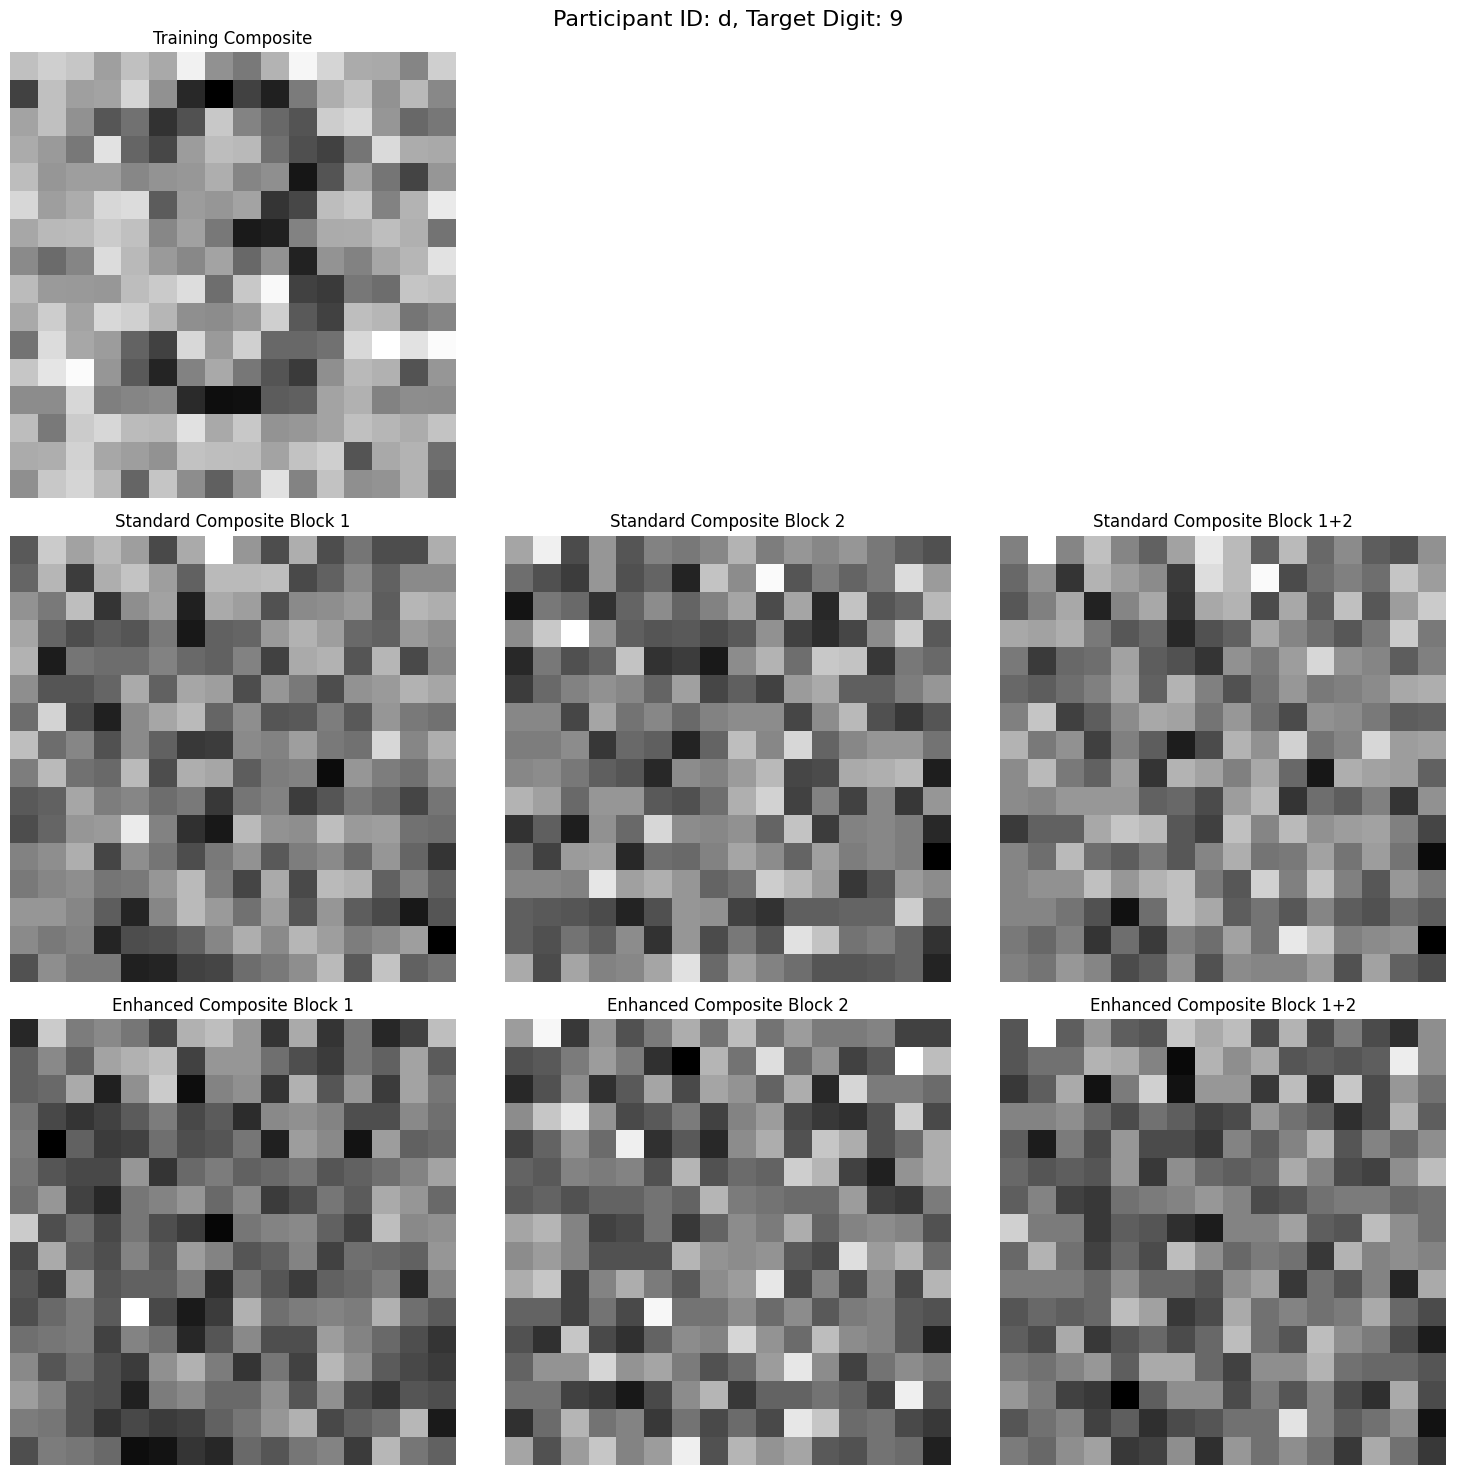

Processing Participant 275555


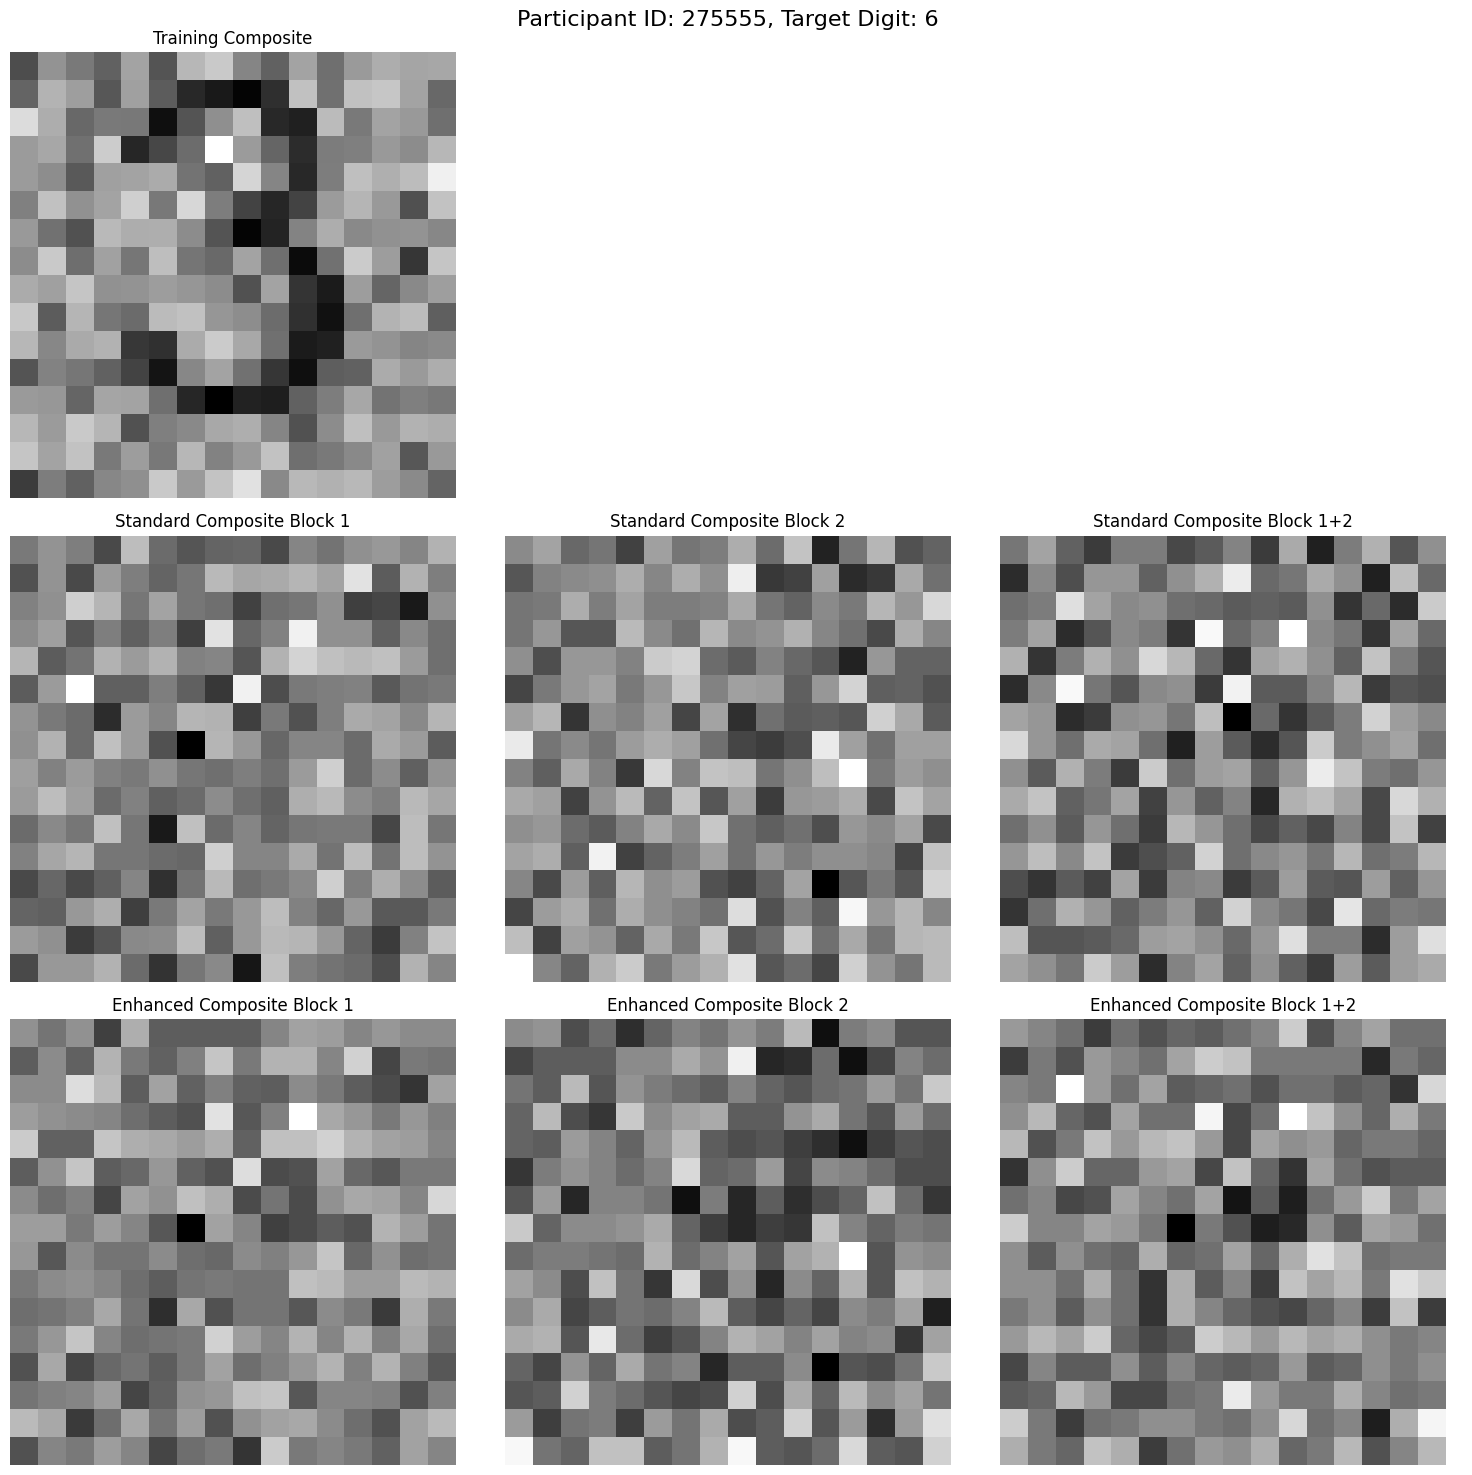

Processing Participant tyl2g22


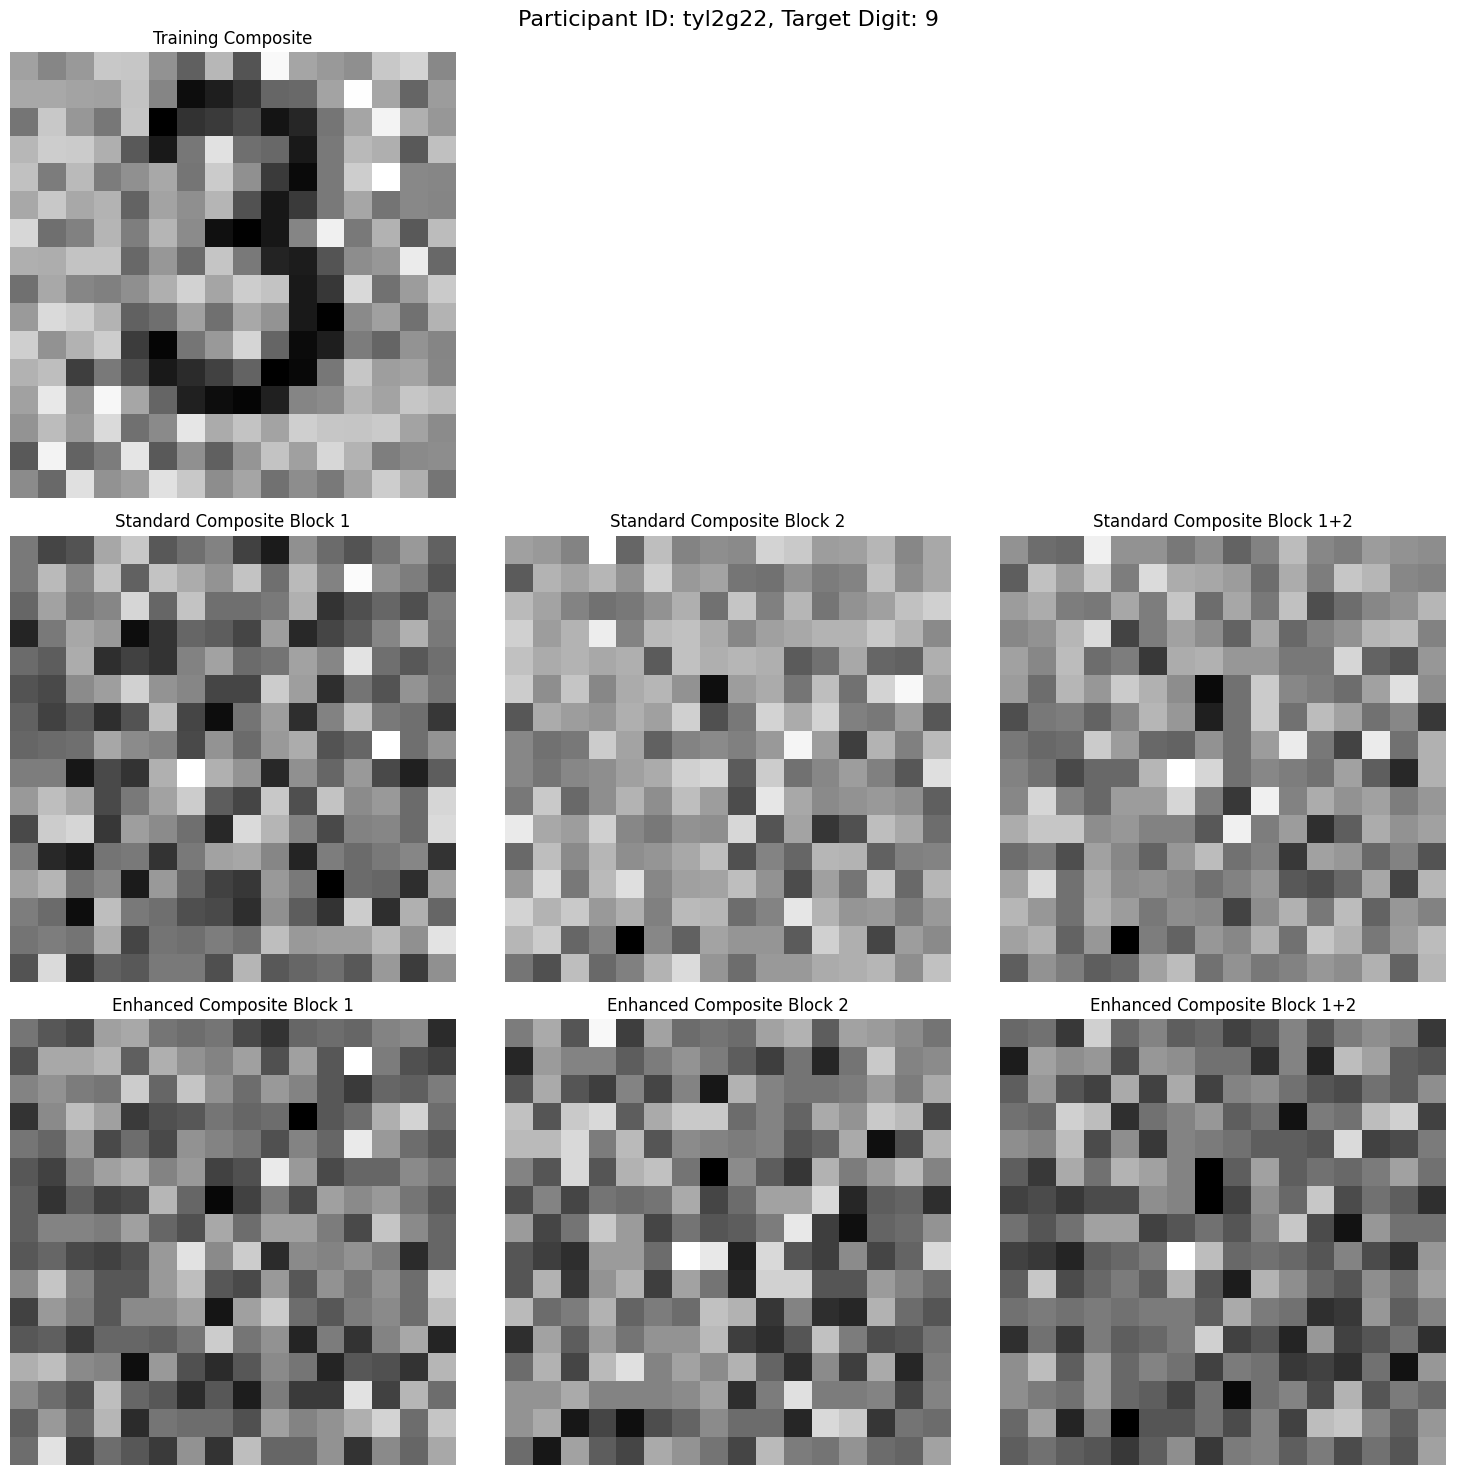

Processing Participant ab8n22


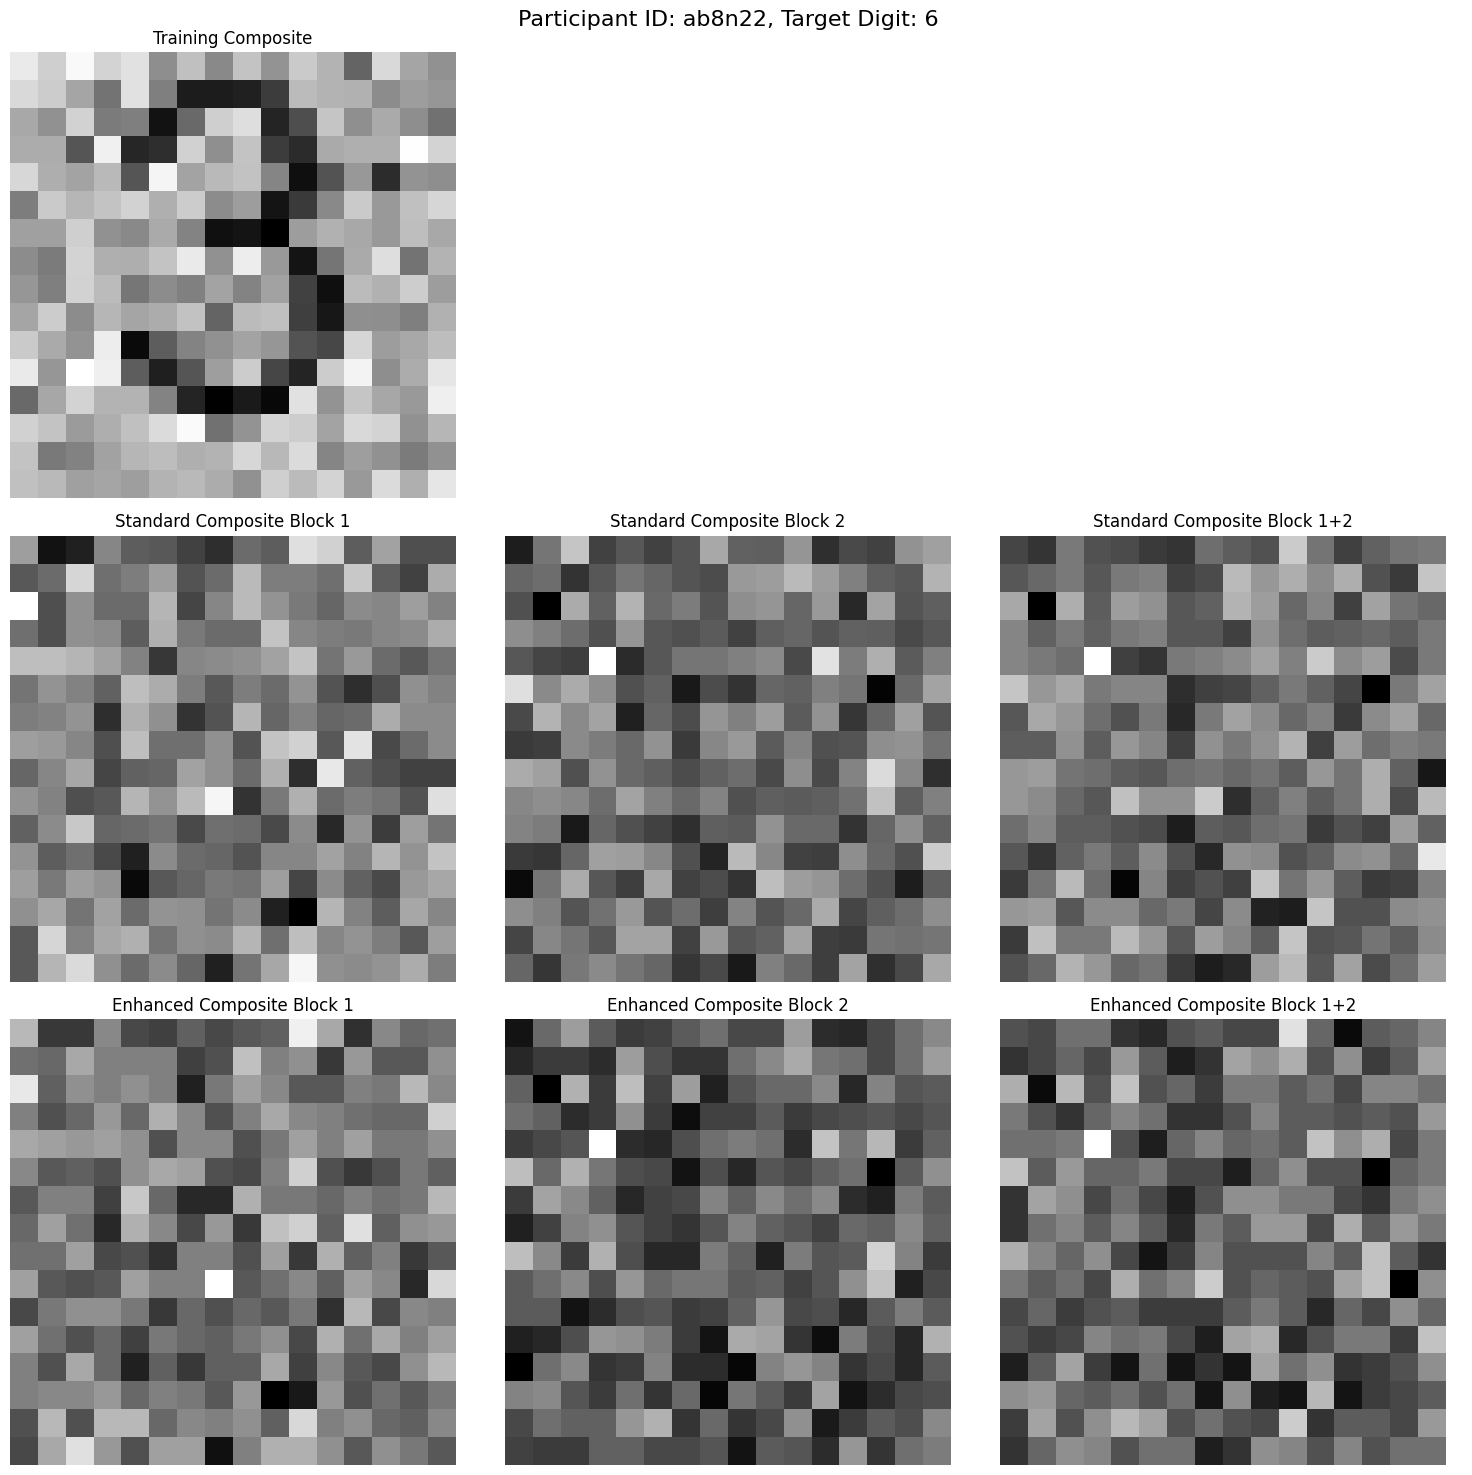

Processing Participant 110424


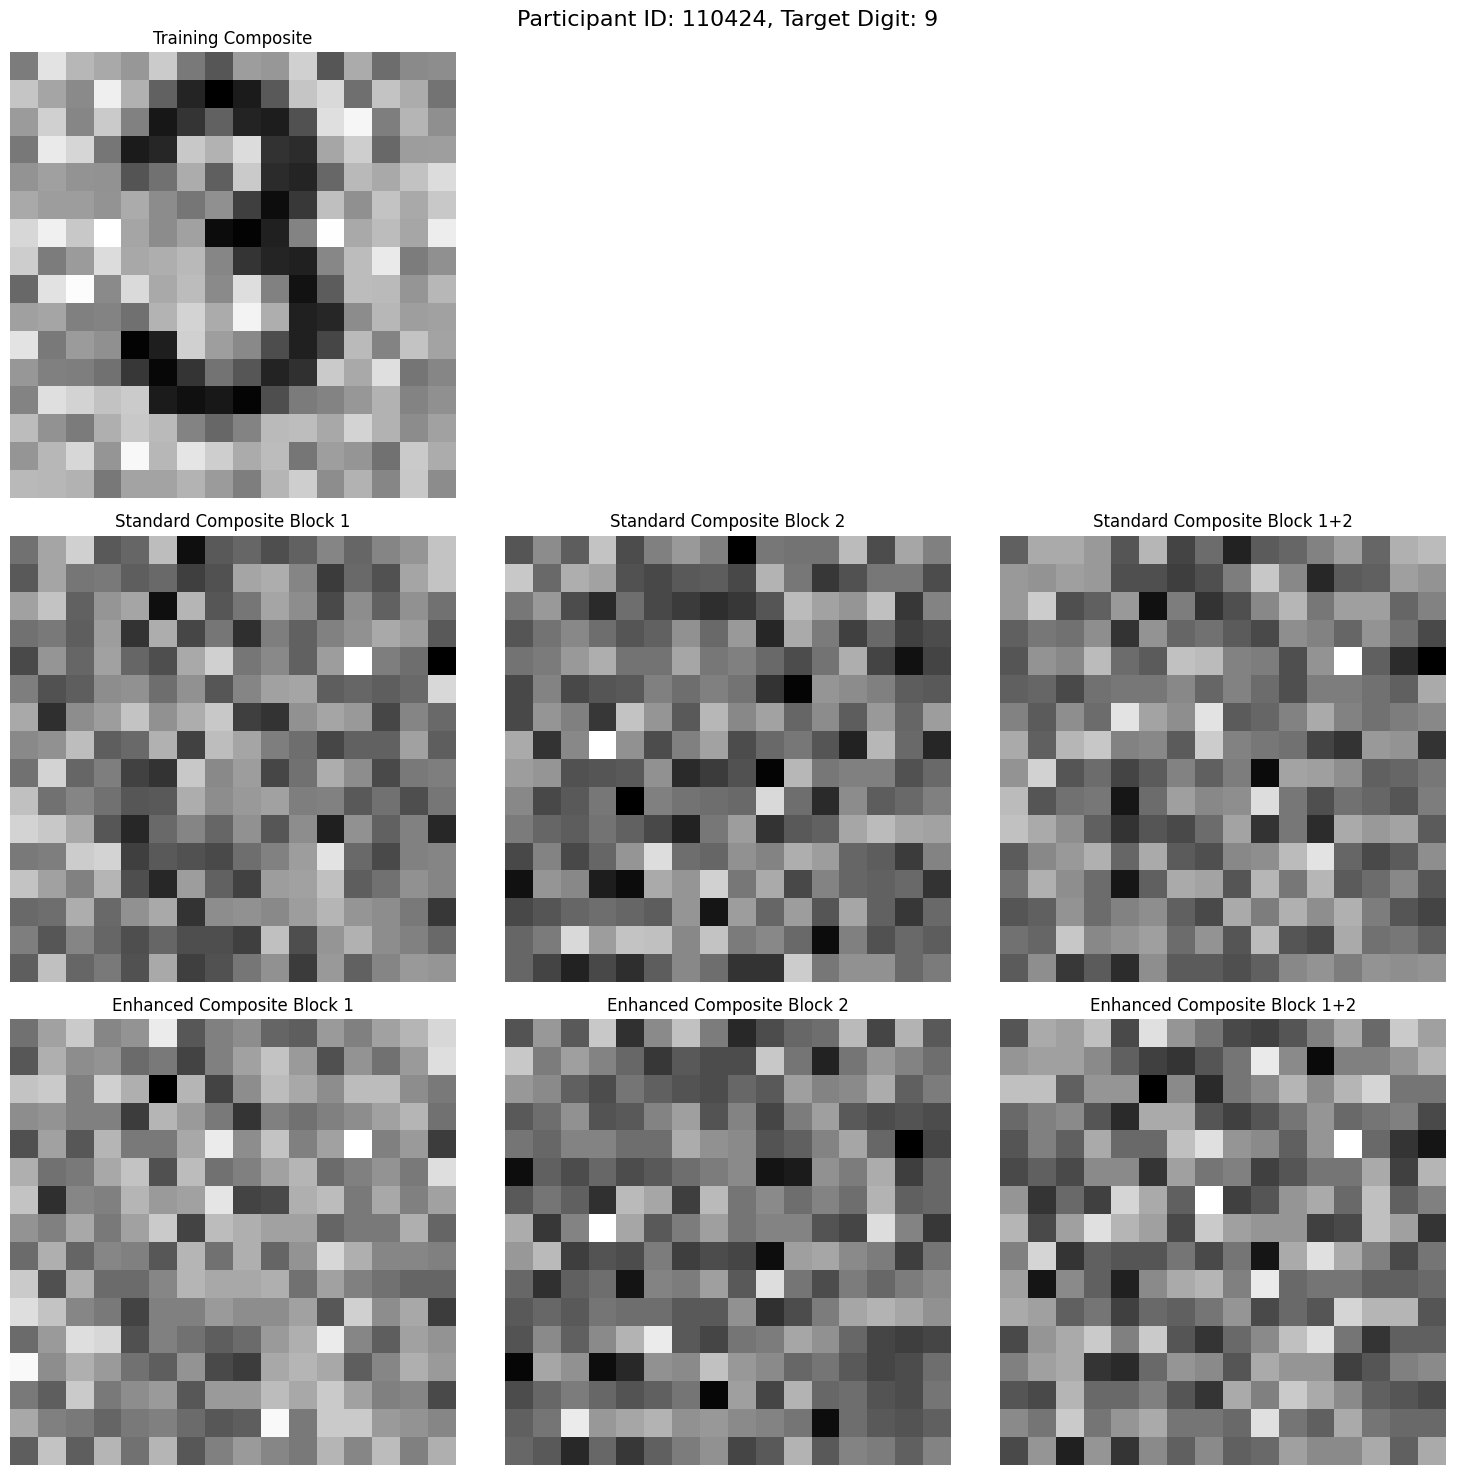

Processing Participant jl18g24


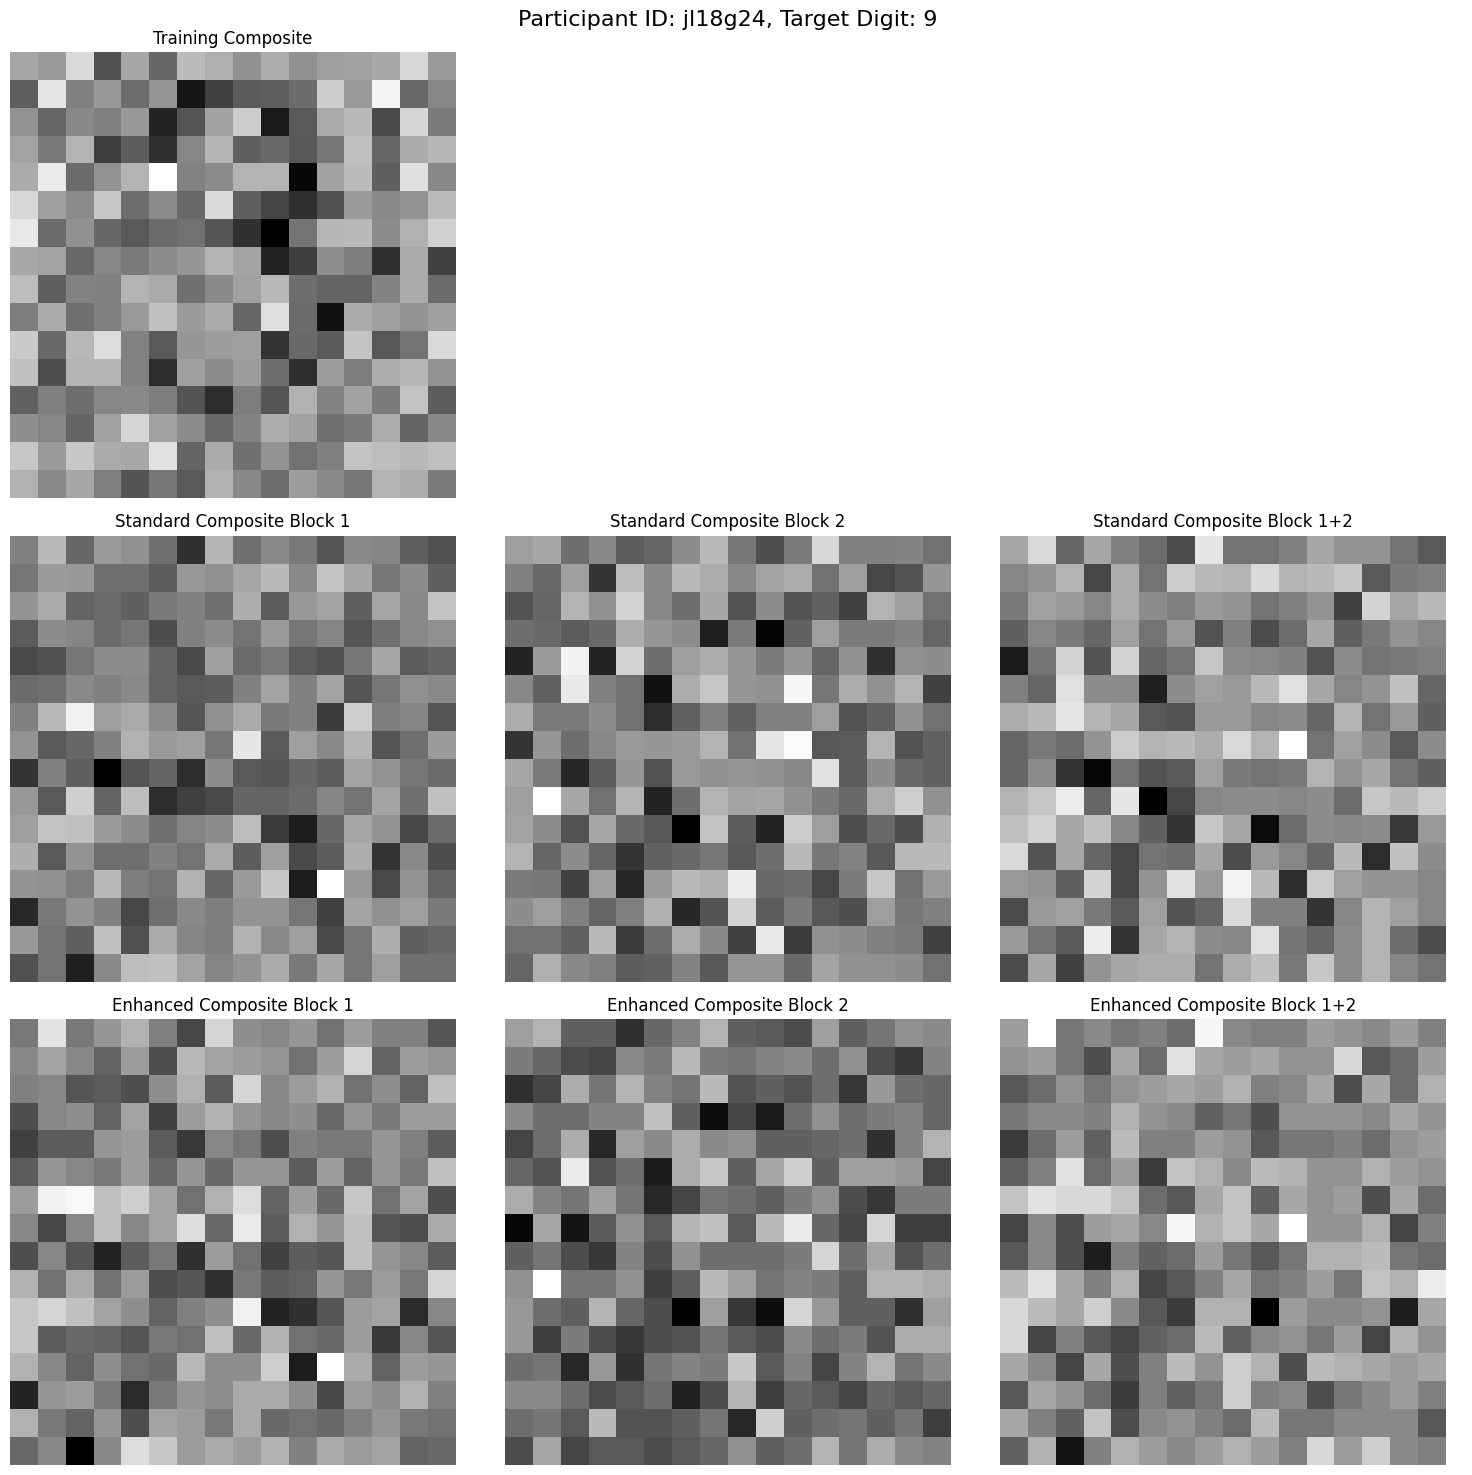

In [18]:
# Function to display composites for a participant along with the target digit
def display_results(participant_id, results):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    # Display target digit in the title
    fig.suptitle(f"Participant ID: {participant_id}, Target Digit: {results['target_digit']}", fontsize=16)

    # Display Training Composite
    axes[0, 0].imshow(results['training_composite'], cmap='gray')
    axes[0, 0].set_title('Training Composite')

    # Display Standard Composites for Block 1, Block 2, and Block 1+2
    for i, block in enumerate([1, 2, '1+2']):
        axes[1, i].imshow(results['standard_composites'][block], cmap='gray')
        axes[1, i].set_title(f'Standard Composite Block {block}')

    # Display Enhanced Composites for Block 1, Block 2, and Block 1+2
    for i, block in enumerate([1, 2, '1+2']):
        axes[2, i].imshow(results['enhanced_composites'][block], cmap='gray')
        axes[2, i].set_title(f'Enhanced Composite Block {block}')

    # Turn off axis for all subplots
    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Main execution loop to process and display results for all participants
for participant_id in summary_df['participant_id']:
    try:
        print(f"Processing Participant {participant_id}")
        
        # Get data for this participant from all_participants_data (assuming it's already loaded)
        participant_data = all_participants_data[participant_id]
        
        # Analyze the participant's data to generate composites and retrieve target digit
        results = analyze_participant(participant_data)
        
        # Display the composites along with the target digit
        display_results(participant_id, results)
        
    except Exception as e:
        print(f"Error processing Participant {participant_id}: {str(e)}")

This doesn't look like much right now, which is fine, we are going to persevere and try to create the mega composite now


Creating mega composites for Target Digit 6...
Standard Composite block1_standard_composite: 2 participants, 2 images used.
Standard Composite block2_standard_composite: 2 participants, 2 images used.
Standard Composite block1_2_standard_composite: 2 participants, 2 images used.
Enhanced Composite block1_enhanced_composite: 2 participants, 2 images used.
Enhanced Composite block2_enhanced_composite: 2 participants, 2 images used.
Enhanced Composite block1_2_enhanced_composite: 2 participants, 2 images used.

Creating mega composites for Target Digit 9...
Standard Composite block1_standard_composite: 4 participants, 4 images used.
Standard Composite block2_standard_composite: 4 participants, 4 images used.
Standard Composite block1_2_standard_composite: 4 participants, 4 images used.
Enhanced Composite block1_enhanced_composite: 4 participants, 4 images used.
Enhanced Composite block2_enhanced_composite: 4 participants, 4 images used.
Enhanced Composite block1_2_enhanced_composite: 4 p

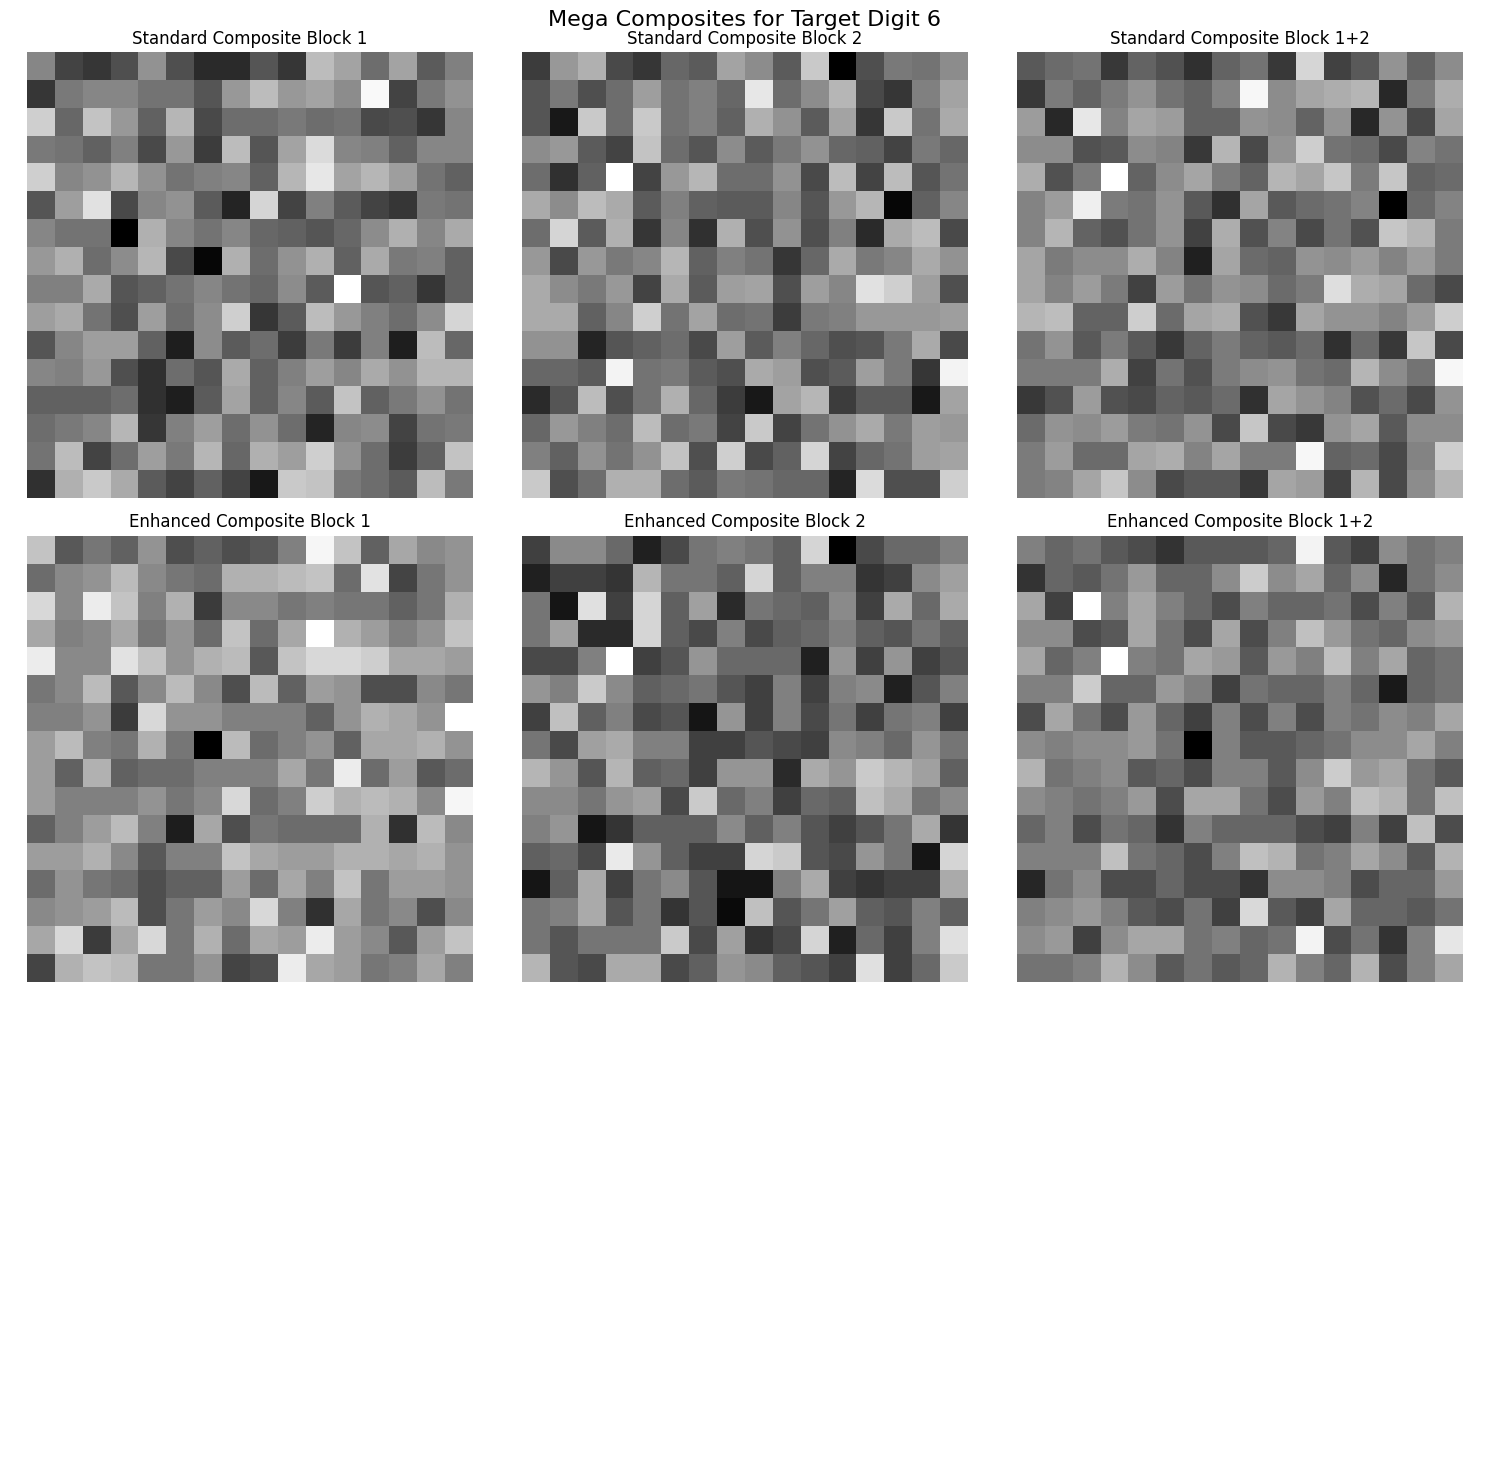


Displaying Mega Composites for Target Digit 9


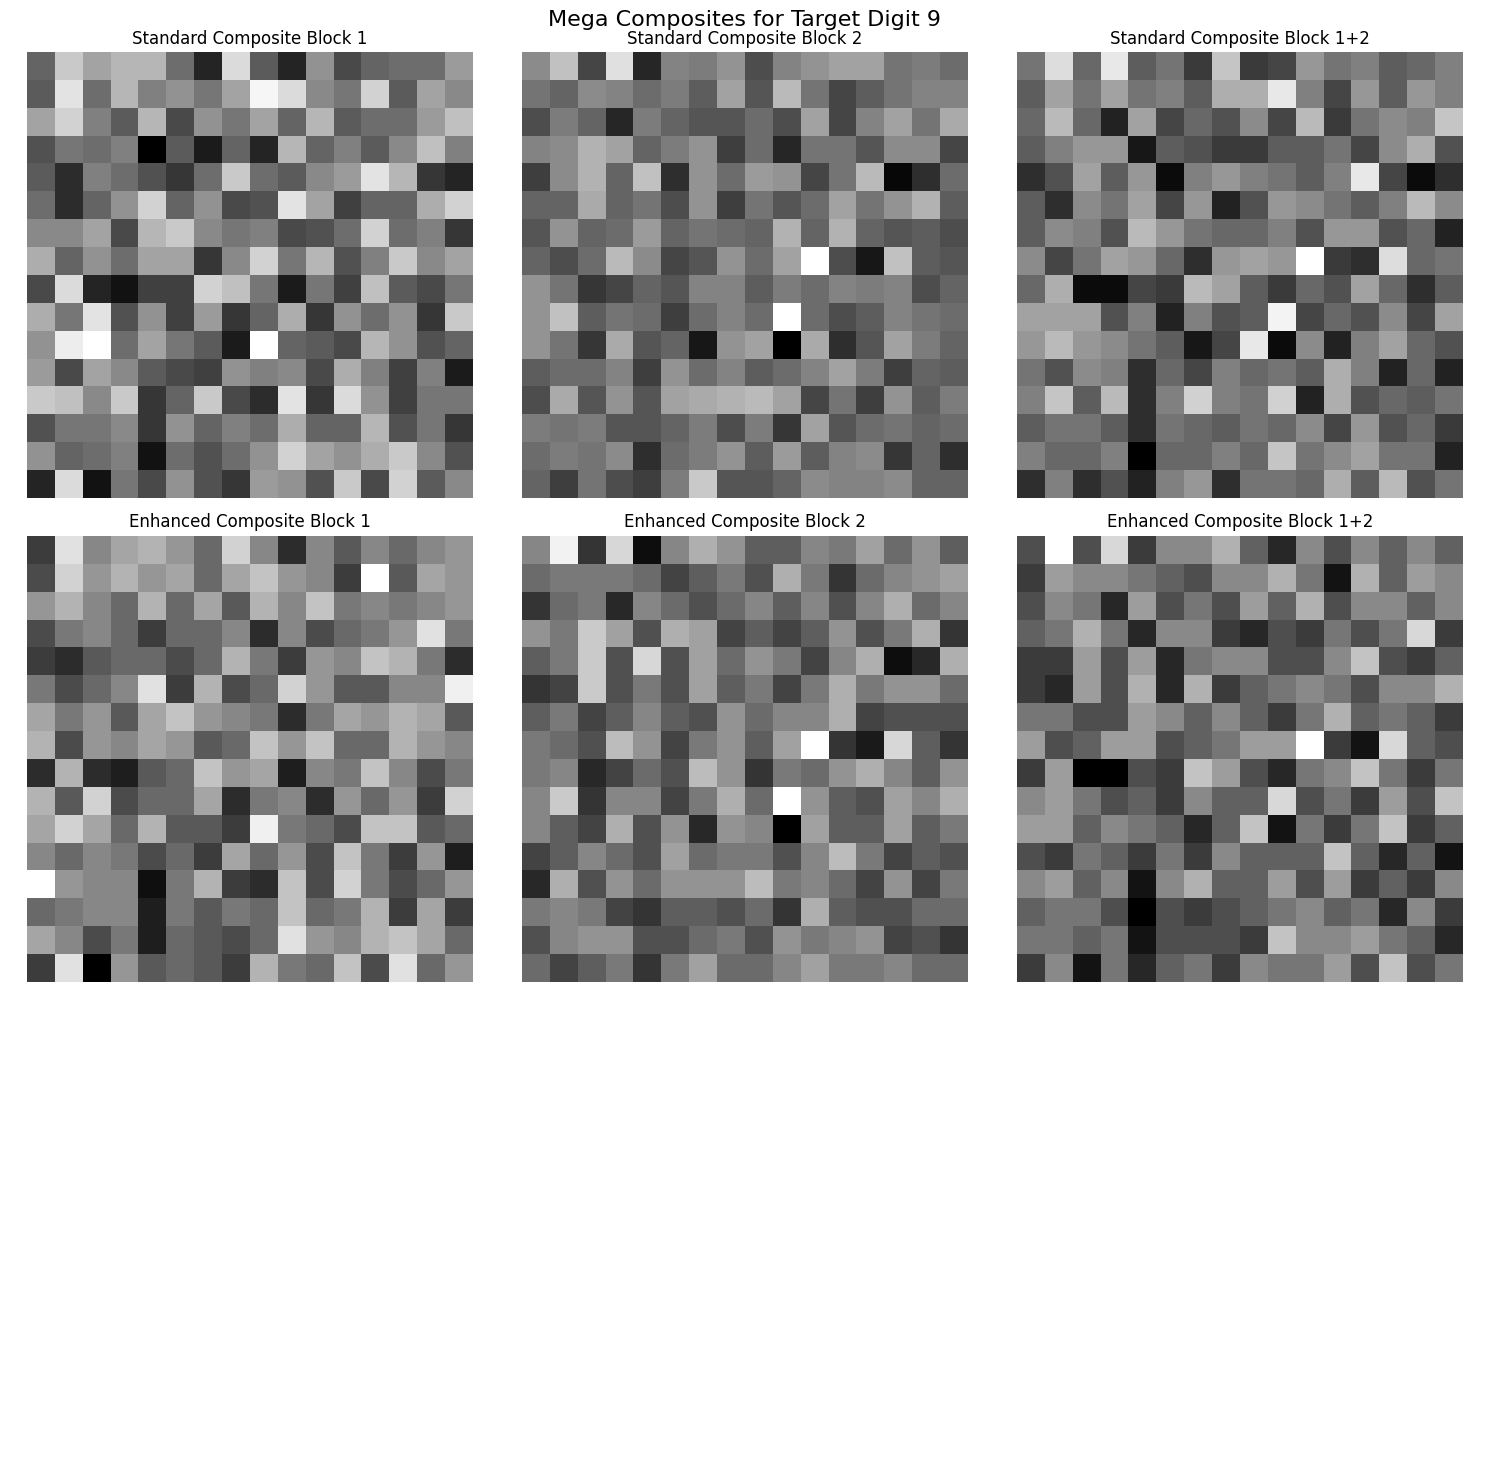

In [19]:
# Function to create mega composites using existing composites in summary_df
def create_mega_composites(summary_df):
    # Separate participants by their target digit (6 or 9)
    digit_groups = {6: [], 9: []}
    
    for idx, row in summary_df.iterrows():
        target_digit = row['main_condition']
        if target_digit in [6, 9]:
            digit_groups[target_digit].append(row)
    
    # Function to average composites for a group of participants
    def average_composite_for_group(participants, composite_field):
        all_composites = [p[composite_field] for p in participants if p[composite_field] is not None]
        
        if not all_composites:
            return np.zeros((16, 16), dtype=np.uint8), 0  # Return an empty image and count 0 if no valid composites
        
        # Stack all composites and compute the mean
        stacked_composites = np.stack(all_composites)
        mean_composite = np.mean(stacked_composites, axis=0)
        
        return mean_composite.astype(np.uint8), len(all_composites)

    # Loop through each digit group (6 and 9) and create mega composites
    mega_composites = {}
    
    for digit in [6, 9]:
        print(f"\nCreating mega composites for Target Digit {digit}...")
        
        # Initialize dictionary to store results
        mega_composites[digit] = {
            'standard_composites': {},
            'enhanced_composites': {},
            'participants': [p['participant_id'] for p in digit_groups[digit]]
        }
        
        # Generate standard and enhanced mega composites for Block 1, Block 2, and Block 1+2
        for block in ['block1_standard_composite', 'block2_standard_composite', 'block1_2_standard_composite']:
            mega_composites[digit]['standard_composites'][block], num_images = average_composite_for_group(digit_groups[digit], block)
            print(f"Standard Composite {block}: {len(digit_groups[digit])} participants, {num_images} images used.")
        
        for block in ['block1_enhanced_composite', 'block2_enhanced_composite', 'block1_2_enhanced_composite']:
            mega_composites[digit]['enhanced_composites'][block], num_images = average_composite_for_group(digit_groups[digit], block)
            print(f"Enhanced Composite {block}: {len(digit_groups[digit])} participants, {num_images} images used.")

    return mega_composites

# Function to display the mega composites
def display_mega_composites(mega_composites):
    for digit in [6, 9]:
        print(f"\nDisplaying Mega Composites for Target Digit {digit}")
        
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        fig.suptitle(f"Mega Composites for Target Digit {digit}", fontsize=16)

        # Display Standard Composites
        axes[0, 0].imshow(mega_composites[digit]['standard_composites']['block1_standard_composite'], cmap='gray')
        axes[0, 0].set_title('Standard Composite Block 1')

        axes[0, 1].imshow(mega_composites[digit]['standard_composites']['block2_standard_composite'], cmap='gray')
        axes[0, 1].set_title('Standard Composite Block 2')

        axes[0, 2].imshow(mega_composites[digit]['standard_composites']['block1_2_standard_composite'], cmap='gray')
        axes[0, 2].set_title('Standard Composite Block 1+2')

        # Display Enhanced Composites
        axes[1, 0].imshow(mega_composites[digit]['enhanced_composites']['block1_enhanced_composite'], cmap='gray')
        axes[1, 0].set_title('Enhanced Composite Block 1')

        axes[1, 1].imshow(mega_composites[digit]['enhanced_composites']['block2_enhanced_composite'], cmap='gray')
        axes[1, 1].set_title('Enhanced Composite Block 2')

        axes[1, 2].imshow(mega_composites[digit]['enhanced_composites']['block1_2_enhanced_composite'], cmap='gray')
        axes[1, 2].set_title('Enhanced Composite Block 1+2')

        # Turn off axis for all subplots
        for ax in axes.flat:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

# Main execution to create and display mega composites
mega_comps = create_mega_composites(summary_df)
display_mega_composites(mega_comps)

Without any sort of filter/smoothing this still doesn't really look like a 9 to the naked eye (at least immediately) but intuitively I am starting to see something here.

In [20]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np

# Define LeNet5 architecture modified for 16x16 images
class LeNet5_16x16(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5_16x16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),  # First conv layer
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)      # Pooling layer
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5), # Second conv layer
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)      # Pooling layer
        )
        # Adjusted fully connected layers for 16x16 input images
        self.fc1 = nn.Linear(16 * 1 * 1, 120)  # Output from conv layers is now smaller due to pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten the tensor for FC layers
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Function to load LeNet5 model for 16x16 images
def load_lenet5_model_16x16(file_path=None):
    model = LeNet5_16x16(num_classes=10)
    if file_path:
        model.load_state_dict(torch.load(file_path))
    return model


Classifying training composite for Participant d...


C:\Users\Sai\AppData\Local\Temp\ipykernel_69536\2337753133.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))  # Load pre-trai

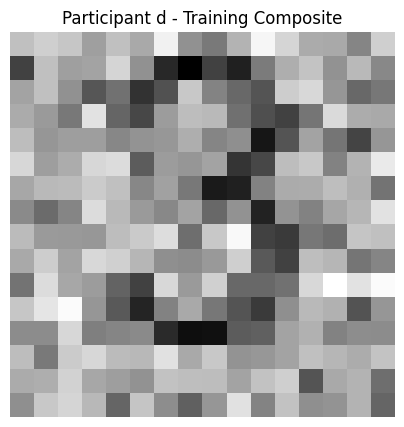

LeNet5 Prediction: 3
Confidence Scores (Descending):
Digit 3: 0.1663
Digit 9: 0.1348
Digit 8: 0.1194
Digit 6: 0.1135
Digit 2: 0.1084
Digit 0: 0.0994
Digit 5: 0.0872
Digit 1: 0.0750
Digit 4: 0.0639
Digit 7: 0.0322
Classifying training composite for Participant 275555...


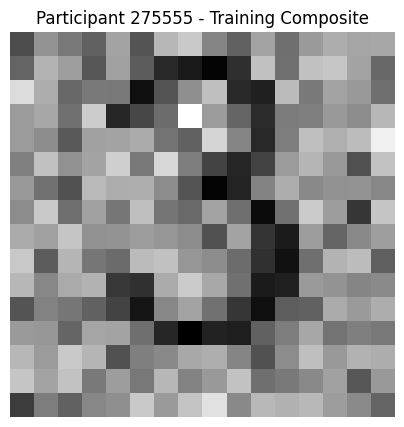

LeNet5 Prediction: 3
Confidence Scores (Descending):
Digit 3: 0.1874
Digit 8: 0.1339
Digit 2: 0.1333
Digit 6: 0.0989
Digit 9: 0.0986
Digit 0: 0.0863
Digit 4: 0.0851
Digit 5: 0.0729
Digit 1: 0.0726
Digit 7: 0.0309
Classifying training composite for Participant tyl2g22...


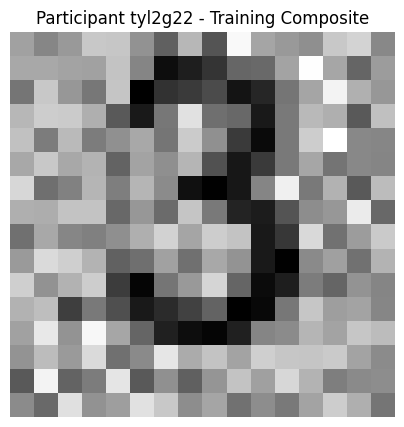

LeNet5 Prediction: 3
Confidence Scores (Descending):
Digit 3: 0.2046
Digit 8: 0.1489
Digit 6: 0.1351
Digit 0: 0.1125
Digit 9: 0.1002
Digit 5: 0.1001
Digit 2: 0.0798
Digit 4: 0.0491
Digit 1: 0.0468
Digit 7: 0.0228
Classifying training composite for Participant ab8n22...


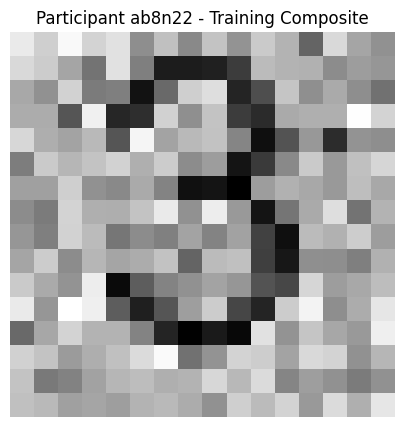

LeNet5 Prediction: 3
Confidence Scores (Descending):
Digit 3: 0.1894
Digit 8: 0.1337
Digit 9: 0.1241
Digit 0: 0.1162
Digit 6: 0.1139
Digit 2: 0.1064
Digit 4: 0.0747
Digit 5: 0.0656
Digit 1: 0.0434
Digit 7: 0.0326
Classifying training composite for Participant 110424...


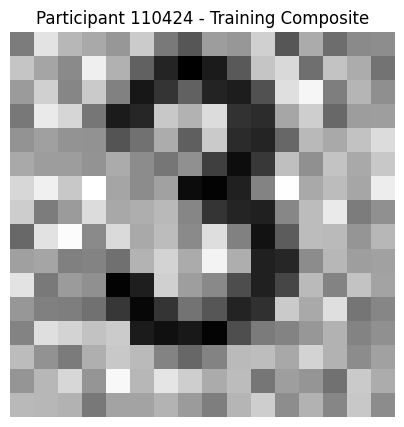

LeNet5 Prediction: 3
Confidence Scores (Descending):
Digit 3: 0.1918
Digit 8: 0.1558
Digit 9: 0.1284
Digit 2: 0.1044
Digit 6: 0.0995
Digit 5: 0.0964
Digit 0: 0.0820
Digit 4: 0.0619
Digit 1: 0.0584
Digit 7: 0.0214
Classifying training composite for Participant jl18g24...


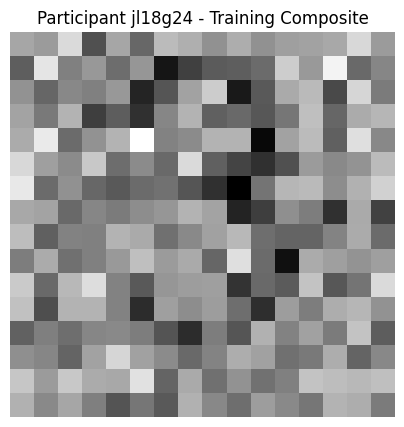

LeNet5 Prediction: 3
Confidence Scores (Descending):
Digit 3: 0.1380
Digit 6: 0.1351
Digit 0: 0.1022
Digit 2: 0.0986
Digit 9: 0.0985
Digit 8: 0.0984
Digit 4: 0.0978
Digit 5: 0.0861
Digit 1: 0.0859
Digit 7: 0.0595


In [21]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Function to create LeNet5 model for MNIST-like grayscale images
class LeNet5_16x16(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5_16x16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(16 * 1 * 1, 120)  # Adjusted for 16x16 input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten the tensor
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Function to load LeNet5 model for 16x16 images with pre-trained weights
def load_lenet5_model_16x16(file_path=None):
    model = LeNet5_16x16(num_classes=10)
    if file_path:
        model.load_state_dict(torch.load(file_path))  # Load pre-trained weights
    return model

# Preprocessing function for input images (resizing and normalizing)
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((16, 16)),  # Resize to match LeNet5 input size (modified for 16x16)
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize for grayscale images (mean=0.1307, std=0.3081)
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Function to classify an image using a given model and return confidence scores for each digit
def classify_image_with_confidence(model, image):
    with torch.no_grad():  # Disable gradient computation for inference
        image_tensor = preprocess_image(image)
        output = model(image_tensor)  # Get raw logits (penultimate layer output)
        confidence_scores = torch.softmax(output, dim=1).cpu().numpy()  # Apply softmax to get probabilities
        predicted_class = torch.argmax(output).item()  # Get predicted class (digit)
        return predicted_class, confidence_scores[0]  # Return both predicted class and confidence scores

# Function to display the training composite and classification results in descending order of confidence scores
def display_training_composite_and_classification(participant_id, training_composite_image, lenet_prediction, lenet_confidences):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    ax.imshow(training_composite_image, cmap='gray')
    ax.set_title(f"Participant {participant_id} - Training Composite")
    ax.axis('off')
    
    plt.show()

    print(f"LeNet5 Prediction: {lenet_prediction}")
    print("Confidence Scores (Descending):")
    
    # Sort confidence scores in descending order and display them
    sorted_indices = np.argsort(lenet_confidences)[::-1]  # Sort indices in descending order of confidence
    for idx in sorted_indices:
        print(f"Digit {idx}: {lenet_confidences[idx]:.4f}")

# Main function to classify training composites with confidence scores using LeNet5
def classify_training_composites_with_lenet(summary_df):
    # Load trained LeNet5 model from file (ensure you have saved it after training)
    lenet_model = load_lenet5_model_16x16('lenet5_trained_model.pth')  # Path to your saved model

    results = {}

    lenet_model.eval()  # Ensure the model is in evaluation mode

    for idx, row in summary_df.iterrows():
        participant_id = row['participant_id']
        print(f"Classifying training composite for Participant {participant_id}...")

        # Get the training composite image from summary_df
        training_composite_image = Image.fromarray(row['training_composite'].astype(np.uint8))

        # Classify using modified LeNet5 and get confidence scores
        lenet_prediction, lenet_confidences = classify_image_with_confidence(lenet_model, training_composite_image)

        # Display the training composite and classification results in descending order of confidence scores
        display_training_composite_and_classification(participant_id, training_composite_image, lenet_prediction, lenet_confidences)

        # Store results for this participant
        results[participant_id] = {
            'lenet_prediction': lenet_prediction,
            'lenet_confidences': lenet_confidences,
            'target_digit': row['main_condition']  # Assuming target digit is stored in 'main_condition'
        }

    return results

# Call the function to classify training composites with confidence scores for all participants using modified LeNet5
classification_results_lenet = classify_training_composites_with_lenet(summary_df)


In [22]:
# Function to analyze predictions and calculate rank and distance from target
def analyze_prediction(prediction, target_digit):
    try:
        predicted_digit = np.argmax(prediction)
        confidence = np.max(prediction)
        target_confidence = prediction[target_digit]
        
        # Sort predictions in descending order of confidence
        sorted_indices = np.argsort(prediction)[::-1]
        
        # Rank of the target digit
        target_rank = np.where(sorted_indices == target_digit)[0][0] + 1  # Add 1 because rank starts at 1
        
        # Distance between most confident prediction and target digit's confidence
        distance = abs(confidence - target_confidence)
        
        return {
            'predicted_digit': predicted_digit,
            'confidence': confidence,
            'target_confidence': target_confidence,
            'target_rank': target_rank,
            'distance': distance,
            'ordered_predictions': [(digit, prediction[digit]) for digit in sorted_indices]
        }
    except Exception as e:
        print(f"Error in analyze_prediction: {str(e)}")
        return None  # Return None if there's an error

In [23]:
# Function to classify an image using a given model and return confidence scores for each digit
def classify_image_with_confidence(model, image):
    # Convert NumPy array to PIL Image if necessary
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image.astype(np.uint8))
    
    with torch.no_grad():  # Disable gradient computation for inference
        image_tensor = preprocess_image(image)
        output = model(image_tensor)  # Get raw logits (penultimate layer output)
        confidence_scores = torch.softmax(output, dim=1).cpu().numpy()  # Apply softmax to get probabilities
        predicted_class = torch.argmax(output).item()  # Get predicted class (digit)
        return predicted_class, confidence_scores[0]  # Return both predicted class and confidence scores

# Function to analyze predictions and calculate rank and distance from target
def analyze_participant(participant_data):
    # Extract target digit from main_condition or another relevant field
    target_digit = participant_data.get('main_condition')  # Assuming main_condition holds the target digit
    
    # Create training composite
    training_composite = create_composite_image(participant_data['training_images'])
    
    # Create standard composites
    standard_composites = {}
    enhanced_composites = {}
    
    for block in [1, 2]:
        selected = participant_data['selected_images'][block]
        non_selected = participant_data['non_selected_images'][block]
        
        # Standard composite
        standard_composites[block] = create_composite_image(selected)
        
        # Enhanced composite
        non_selected_reshaped = [non_selected[i:i+9] for i in range(0, len(non_selected), 9)]
        enhanced_composites[block] = create_enhanced_composite(selected, non_selected_reshaped)
    
    # Create block 1+2 composites
    all_selected = participant_data['selected_images'][1] + participant_data['selected_images'][2]
    all_non_selected = participant_data['non_selected_images'][1] + participant_data['non_selected_images'][2]
    
    standard_composites['1+2'] = create_composite_image(all_selected)
    
    all_non_selected_reshaped = [all_non_selected[i:i+9] for i in range(0, len(all_non_selected), 9)]
    enhanced_composites['1+2'] = create_enhanced_composite(all_selected, all_non_selected_reshaped)
    
    return {
        'training_composite': training_composite,
        'standard_composites': standard_composites,
        'enhanced_composites': enhanced_composites,
        'target_digit': target_digit  # Ensure target digit is included here
    }

# Function to classify all composites for a participant and analyze results
def classify_and_analyze_composites(lenet_model, participant_id, participant_data):
    results = []
    
    print(f"Processing Participant {participant_id}")
    
    if 'main_condition' not in participant_data:
        print(f"Error: 'main_condition' (target digit) not found for Participant {participant_id}")
        return results
    
    target_digit = participant_data['main_condition']
    
    # Analyze training composite
    training_composite = participant_data['training_composite']
    lenet_prediction, lenet_confidences = classify_image_with_confidence(lenet_model, training_composite)
    analysis_result = analyze_prediction(lenet_confidences, target_digit)
    
    if analysis_result is not None:
        results.append({
            'composite_type': 'Training',
            'block': 'N/A',
            'target': target_digit,
            **analysis_result
        })
    
    # Analyze standard composites for each block (1, 2, and combined 1+2)
    for block in ['block1_standard_composite', 'block2_standard_composite', 'block1_2_standard_composite']:
        composite_image = participant_data[block]
        lenet_prediction, lenet_confidences = classify_image_with_confidence(lenet_model, composite_image)
        analysis_result = analyze_prediction(lenet_confidences, target_digit)
        
        if analysis_result is not None:
            results.append({
                'composite_type': 'Standard Composite',
                'block': block,
                'target': target_digit,
                **analysis_result
            })
    
    # Analyze enhanced composites for each block (1, 2, and combined 1+2)
    for block in ['block1_enhanced_composite', 'block2_enhanced_composite', 'block1_2_enhanced_composite']:
        composite_image = participant_data[block]
        lenet_prediction, lenet_confidences = classify_image_with_confidence(lenet_model, composite_image)
        analysis_result = analyze_prediction(lenet_confidences, target_digit)
        
        if analysis_result is not None:
            results.append({
                'composite_type': 'Enhanced Composite',
                'block': block,
                'target': target_digit,
                **analysis_result
            })
    
    return results

# Main function to classify all participants' composites and store results in a DataFrame
def classify_all_participants(summary_df):
    lenet_model = load_lenet5_model_16x16('lenet5_trained_model.pth')  # Load trained LeNet5 model
    
    all_results = []
    
    for idx, row in summary_df.iterrows():
        participant_id = row['participant_id']
        
        print(f"Classifying composites for Participant {participant_id}...")
        
        # Analyze all composites for this participant using main_condition as the target digit
        participant_results = classify_and_analyze_composites(lenet_model, participant_id, row)
        
        # Append results to overall list
        all_results.extend(participant_results)
    
    # Convert results to DataFrame for easy viewing
    results_df = pd.DataFrame(all_results)
    
    return results_df

# Call the function to classify all participants' composites and display results as a DataFrame
classification_results_df = classify_all_participants(summary_df)

# Display the classification results DataFrame
print(classification_results_df.head())

Classifying composites for Participant d...
Processing Participant d
Classifying composites for Participant 275555...
Processing Participant 275555
Classifying composites for Participant tyl2g22...
Processing Participant tyl2g22
Classifying composites for Participant ab8n22...
Processing Participant ab8n22
Classifying composites for Participant 110424...
Processing Participant 110424
Classifying composites for Participant jl18g24...
Processing Participant jl18g24
       composite_type                        block  target  predicted_digit  \
0            Training                          N/A       9                3   
1  Standard Composite    block1_standard_composite       9                1   
2  Standard Composite    block2_standard_composite       9                4   
3  Standard Composite  block1_2_standard_composite       9                1   
4  Enhanced Composite    block1_enhanced_composite       9                4   

   confidence  target_confidence  target_rank  distance  

C:\Users\Sai\AppData\Local\Temp\ipykernel_69536\2337753133.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))  # Load pre-trai